# Debugging your python code

_Ivan Oreshnikov <ioreshnikov@tuebingen.mpg.de> on August 29, 2019_

<img src=" 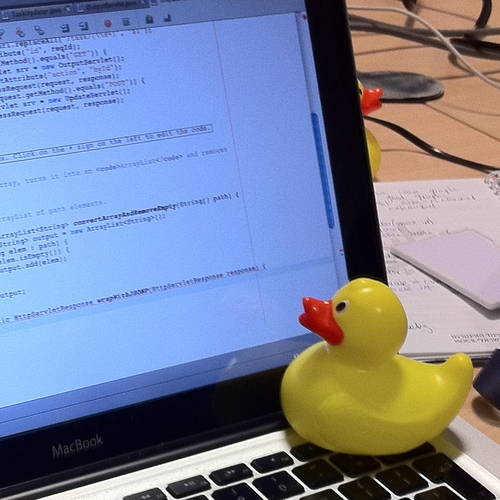" title="Rubber duck debugging" style="width: 500px"/>

## Introduction

> If debugging is the process of removing bugs, then programming must be the process of putting them in.
>
> _Edsger W. Dijkstra_

Almost all the code we write, with very rare exceptions, is filled with errors. That's not unique to us, being researchers, that's a universal truth. Steve McConnel in his [Code Complete](https://www.amazon.com/Code-Complete-Practical-Handbook-Construction/dp/0735619670) uses the metrics of errors per 1000 lines of code and provides the following estimates

> (a) Industry Average: "about 15 - 50 errors per 1000 lines of delivered code." He further says this is usually representative of code that has some level of structured programming behind it, but probably includes a mix of coding techniques.
>
> (b) Microsoft Applications: "about 10 - 20 defects per 1000 lines of code during in-house testing, and 0.5 defect per KLOC (KLOC IS CALLED AS 1000 lines of code) in released product (Moore 1992)." He attributes this to a combination of code-reading techniques and independent testing (discussed further in another chapter of his book).
>
> (c) "Harlan Mills pioneered 'cleanroom development', a technique that has been able to achieve rates as low as 3 defects per 1000 lines of code during in-house testing and 0.1 defect per 1000 lines of code in released product (Cobb and Mills 1990). A few projects - for example, the space-shuttle software - have achieved a level of 0 defects in 500,000 lines of code using a system of format development methods, peer reviews, and statistical testing."

But those are the estimates for the delivered code. In the process of writing we routinely have to find and fix the errors. Debugging is an inevitable and natural part of programming.

So let us discuss some debugging techniques.

## Good old print statement

This is probably the very first instrument you are reaching for when finding an error. Just insert a print statement an try to peek what's going on inside the code. You have probably seen the code like this multiple times

```python
print("TRYING TO LOG USER {}".format(username))
user = self.find_user(username=username)
if not user:
    print("!!!NOT FOUND!!!")
    raise UserDoesNotExist()
    
pwhash = self.hash_password(password)
if not user.pwhash == pwhash:
    print("!!!WRONG PASSWORD!!!")
    raise PasswordMismatch()
    
if user.is_blocked:
    print("!!!BLOCKED!!!")
    raise UserBlocked()
```

There is nothing wrong with using `print`. The advantage is obvious -- it is extremely easy. The disadvantage is also obvious -- you have to rerun your code if you want to verify another statement. Also, of course, you have to be sure you do not forget them in your code before releasing it.

But you can make those `print` statements perfectly legitimate and leave them in the code even for the release to be able to debug the program without any further modifications of the code. Those print statements are basically just a debug log that is written to `stdout` during the execution. If we use python's `logging` module we can write basically the same log, but with a little bit more control over message visibility.

```python
import logging
import os


if "DEBUG" in os.environ:
    level = logging.DEBUG
else:
    level = logging.INFO
    
logging.basicConfig(level=level)


logging.debug("Trying to log user {}".format(username))
user = self.find_user(username=username)
if not user:
    logging.debug("User not found.")
    raise UserDoesNotExist()
    
pwhash = self.hash_password(password)
if not user.pwhash == pwhash:
    logging.debug("Wrong password provided by the user.")
    raise PasswordMismatch()
    
if user.is_blocked:
    logging.info("User {} is blocked.".format(username))
    raise UserBlocked()
    
logging.info("Succesfully logged in user {}".format(username)
```

By default the log messages are going to be written into `stderr`, but you can either redirect them into a text file or your system journal facility (`syslog` or `journald` in case of linux).

## A proper debugger

When a simple `print` statement is not enough we might reach for a more sophisticated tool, and the name of the tool is a _debugger_. Debuggers let you stop the execution of a program at an arbitrary point and follow the flow of your program line-by-line, inspecting the objects you see in memory and evaluating arbitrary expressions with those objects.

There are several debuggers available for python, but the core concepts they are using are universal -- and not only across the implementations, but the languages as well. We are going to discuss `pdb` -- this is the default python debugger and it comes preinstalled with your python distribution.

To illustrate what is a debugger we first will consider a non-interactive example of a session. Don't worry, you'll have a chance to run an interactive session in this very notebook a little bit later! Consider the following sample
```python
#!/usr/bin/env python3


class Person:
    def __init__(self, first_name, last_name):
        self.first_name = first_name
        self.last_name = last_name
        
    def print_introduction(self):
        introduction = "Hello, my name is {} {}".format(
            self.first_name, self.first_name)
        print(introduction)
            
            
p = Person("John", "Doe")
p.print_introduction()
```

The code above has an obvious error in `print_introduction()` function and instead of printing `Hello, my name is John Doe` we will see the message `Hello, my name is John John`. Let's try to run this code in a debugger session. To start our debugger session we place the following line
```python
import pdb; pdb.set_trace()
```
before you define your person
```python
import pdb; pdb.set_trace()
p = Person("John", "Doe")
```
and then we run our program as usual. But instead of simply seeing the program being executed, we will see the following prompt
```
$ python3 person.py
> /home/ioreshnikov/Code/person.py(16)<module>()
-> p = Person("John", "Doe")
(Pdb) _
```
We are now inside an interactive debugger session. The line starting with an arrow tells us where exactly in the code we are. The line starting with `(Pdb)` is the command line.

At this moment the execution of the program is paused. Now we can interact with the objects in memory, evaluate different python expression or control the flow of the program. All of this is done via the command line. 

### Getting help

Interactive help for the commands can be invoked by `help` command.
```
(Pdb) help

Documented commands (type help <topic>):
========================================
EOF    c          d        h         list      q        rv       undisplay
a      cl         debug    help      ll        quit     s        unt      
alias  clear      disable  ignore    longlist  r        source   until    
args   commands   display  interact  n         restart  step     up       
b      condition  down     j         next      return   tbreak   w        
break  cont       enable   jump      p         retval   u        whatis   
bt     continue   exit     l         pp        run      unalias  where    

Miscellaneous help topics:
==========================
exec  pdb

(Pdb) 
```

### Listing the code around you

To display the code around your current line you can use `list` command (you can also simply type `l`).
```
(Pdb) list
 11  	            self.first_name, self.first_name)
 12  	        print(introduction)
 13  	
 14  	
 15  	import pdb; pdb.set_trace()
 16  ->	p = Person("John", "Doe")
 17  	p.print_introduction()
[EOF]
```

### Executing a single line in the code

To execute a single line use `next` command. You will see that the arrow is moved to the next line
```
(Pdb) next
> /home/ioreshnikov/Code/person.py(17)<module>()
-> p.print_introduction()
```

### Executing arbitrary python code

Whatever you type in the command line, if it's not recognized as a debugger command, will be evaluated by the python interpreter. This way you can inspect the state of the program. For example
```
(Pdb) print(p)
<__main__.Person object at 0x7f34afc029e8>
(Pdb) print(p.first_name)
John
(Pdb) print(p.last_name)
Doe
```

### Stepping inside the functions

At this point, if we call `next` one more time, debugger will execute the line `p.print_introduction()` the wrong error message will be printed and then the program will terminate. But we want to examine what's happening inside `print_introduction`. To step inside the function we can use `step` command
```
(Pdb) step
--Call--
> /home/ioreshnikov/Code/person.py(9)print_introduction()
-> def print_introduction(self):
(Pdb) list
  4  	class Person:
  5  	    def __init__(self, first_name, last_name):
  6  	        self.first_name = first_name
  7  	        self.last_name = last_name
  8  	
  9  ->	    def print_introduction(self):
 10  	        introduction = "Hello, my name is {} {}".format(
 11  	            self.first_name, self.first_name)
 12  	        print(introduction)
 13  	
 14  	
(Pdb) 
```

`next` navigates line by line. So calling `next` once will step us inside the function definition, calling it twice will move us to line 11, but still won't evaluate `introduction`. Finally, calling `next` the third time we see
```
(Pdb) next
> /home/ioreshnikov/Code/person.py(12)print_introduction()
-> print(introduction)
```

Before stepping into the function we have examined the first and the last name of the person and they are set correctly. Yet, if we evaluate the next line we will see a wrong message
```
(Pdb) next
Hello, my name is John John
--Return--
> /home/ioreshnikov/Code/person.py(12)print_introduction()->None
-> print(introduction)
```
So the problem is somewhere in the previous statement. And of course, looking at line 11 we see that the first name was used twice.

### Jumping inside the code

Suppose you are already in the debugger session and want to execute the command up until as certain point. Let's say we are starting in a fresh session and want to jump directly to the line 12 `print(introduction)`. To do so we can use breakpoints. To set up a breakpoint type `break 12`
```
(Pdb) break 12
Breakpoint 1 at /home/ioreshnikov/Code/person.py:12
```
Then to continue executing your code up to a breakpoint simply type `continue`.
```
(Pdb) continue
> /home/ioreshnikov/Code/person.py(12)print_introduction()
-> print(introduction)
```

### Hard-coding a breakpoint into a source code

Sometimes you don't want to start a debugging session right away, but only when a certain condition fails. Since the debugger session is invoked programmatically, you can simply write the call to the debugger session explicitly! For example, we could simply have rewritten the code as follows
```python
#!/usr/bin/env python3


import pdb


class Person:
    def __init__(self, first_name, last_name):
        self.first_name = first_name
        self.last_name = last_name

    def print_introduction(self):
        introduction = "Hello, my name is {} {}".format(
            self.first_name, self.first_name)

        if self.last_name not in introduction:
            pdb.set_trace()

        print(introduction)


p = Person("John", "Doe")
p.print_introduction()
```
This way we will immediately start a debugger session if the last name is not anywhere in the introduction.

### Quitting the debugger session

To quit the session simply type `quit` into the command line.

In [3]:
try:
    x = 100
    raise ValueError()
except Exception as e:
    import pdb; pdb.set_trace()

--Return--
None
> /tmp/ipykernel_149596/307386519.py(5)<module>()
      1 try:
      2     x = 100
      3     raise ValueError()
      4 except Exception as e:
----> 5     import pdb; pdb.set_trace()

ipdb> help

Documented commands (type help <topic>):
EOF    commands   enable    ll        pp       s                until 
a      condition  exit      longlist  psource  skip_hidden      up    
alias  cont       h         n         q        skip_predicates  w     
args   context    help      next      quit     source           whatis
b      continue   ignore    p         r        step             where 
break  d          interact  pdef      restart  tbreak         
bt     debug      j         pdoc      return   u              
c      disable    jump      pfile     retval   unalias        
cl     display    l         pinfo     run      undisplay      
clear  down       list      pinfo2    rv       unt            

Miscellaneous help topics:
exec  pdb

ipdb> quit()


BdbQuit: 

## Interactive example

It turns out that `pdb` works inside `jupyter` as well! This is why we have an opportunity to test our skills right here right now. 

Consider the following problem: you have a certain sum of money and an infinite supply of coins valued at $\{c_1, c_2, ..., c_n\}$ euros. You want to write a function that tells you how to get this sum using the coins you have using the minimum number of coins. For example, you have 1, 2, and 5 euro coins and want to get 13 euros with those coins. Then you'd have to take two 5 euro coins, one 2 euro coin and a 1 euro coin.

Below you can find a non-working attempt at solving the problem. It probably has a lot of bugs, but three of them were put intentionally :) Get your debugger and see if you can fix the problem yourself.

**NOTE**: Please be sure that you leave the debugging session with `quit` before trying to reevaluate any cell. Doing otherwise will hang the kernel.

In [1]:
def change(sum_, coins, stack=None):
    """
    Given a desired sum of money and an infinite supply of coins with
    values {c1, c2, ..., cN} find a way to split the sum with the
    least possible number of coins.

    :param int sum_: A sum of money to split.
    :param list coins: A list of coin values.
    :param list stack: An optional intermediate list of currently picked coins.
    """
    
    # A list that represents the stack of coins we have picked so far.
    if not stack:
        stack = []
        
    if sum_ == 0:
        return stack

    # Find the largest coin smaller than the current sum, put it into
    # the stack and proceed with the remaining sum.
    largest_coin = find_largest_coin(sum_, coins)
    stack.append(largest_coin)
    return change(sum_ - largest_coin, coins, stack)


def find_largest_coin(sum_, coins):
    """
    From a list of coins pick the largest one that is still smaller
    than the desired sum.

    :param int sum_: A sum of money.
    :param list coins: A list of coin values.
    """
    largest = 0

    for value in coins:
        if value <= sum_:
            if value > largest:
                largest = value

    return largest

print(change(10, [5, 2, 1]))  # We expect to see [5, 5]

[5, 5]


# Supplementary materials

1. https://docs.python.org/3/library/pdb.html -- official documentation for `pdb`.
2. https://pypi.org/project/ipdb/ -- an enhanced version of `pdb` with syntax highlighting and autocompletion. **NOTE**: Unfortunately, does not work inside a `jupyter` notebook.
3. https://en.wikipedia.org/wiki/Rubber_duck_debugging -- this is why we have a rubber duck in the beginning of the notebook.